In [1]:
# code for google colab
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
! ls /mydrive

Mounted at /content/gdrive
 activity				    mcm2022
 beast					   'MOHAMMED RISHIN.gdoc'
 certificate.pdf			    Mohammed-Rishin.pdf
 Classroom				   'My Drive'
'Colab Notebooks'			   'object detection'
'Copy of IMG_2891.heic'			   'OFF STAGE ITEMS.gsheet'
 d22					   'ON STAGE ITEMS.gsheet'
 DATAFILE4.jpg				    oven.pdf
'DBMS Test-1 Marks (1).gsheet'		    Pics
 F3823F60-626C-4E13-9CE0-C0A98065606D.png   project_helmet
 Files					    Resume.gdoc
 GROUP.gsheet				   'SRS_Rollno-08 (1).docx'
 helmet_detection			   'SRS_Rollno-08 (2).docx'
 IMG_7878.PNG				   'SRS_Rollno-08 (3).docx'
 kia					    SRS_Rollno-08.docx
'Ladder Ashli (1).gslides'		   'Untitled document.gdoc'
'Ladder Ashli (2).gslides'		   'Untitled document.pdf'
'Ladder Ashli (3).gslides'		   'Untitled folder'
'Ladder Ashli.gslides'			   'Untitled presentation.gslides'
'Ladder Ashli.pptx'


# New Section

In [2]:
# ls
# dataset face_detector
# ls dataset
# with_helmet without_helmet
# ls face_detector
!ls /mydrive/helmet_detection


with_helmet  without_helmet


In [3]:
# edit this directory location
import os
DIRECTORY = "/mydrive/helmet_detection"
CATEGORIES = ["with_helmet", "without_helmet"]

In [4]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
      img_path = os.path.join(path, img)
      print(img_path)

/mydrive/helmet_detection/with_helmet/IMG_9989.jpg
/mydrive/helmet_detection/with_helmet/IMG_9987.jpg
/mydrive/helmet_detection/with_helmet/IMG_9985.jpg
/mydrive/helmet_detection/with_helmet/IMG_9991.jpg
/mydrive/helmet_detection/with_helmet/IMG_9990.jpg
/mydrive/helmet_detection/with_helmet/IMG_9986.jpg
/mydrive/helmet_detection/with_helmet/IMG_9993.jpg
/mydrive/helmet_detection/with_helmet/IMG_9988.jpg
/mydrive/helmet_detection/with_helmet/IMG_9994.jpg
/mydrive/helmet_detection/with_helmet/IMG_9992.jpg
/mydrive/helmet_detection/with_helmet/IMG_9995.jpg
/mydrive/helmet_detection/with_helmet/IMG_9996.jpg
/mydrive/helmet_detection/with_helmet/IMG_9997.jpg
/mydrive/helmet_detection/with_helmet/IMG_9998.jpg
/mydrive/helmet_detection/with_helmet/IMG_9999.jpg
/mydrive/helmet_detection/with_helmet/IMG_0001.jpg
/mydrive/helmet_detection/with_helmet/IMG_0002.jpg
/mydrive/helmet_detection/with_helmet/IMG_0004.jpg
/mydrive/helmet_detection/with_helmet/IMG_0003.jpg
/mydrive/helmet_detection/with_

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [6]:
tf.__version__

'2.12.0'

In [7]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [8]:
# edit this directory location
DIRECTORY = "/mydrive/helmet_detection"
CATEGORIES = ["with_helmet", "without_helmet"]


In [9]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

[INFO] loading images...


In [10]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

In [11]:
#Label Binarizer is an SciKit Learn class that accepts Categorical data as input and returns an Numpy array.
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# convert labels into numbers
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [12]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [13]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [14]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 0s 0us/step


In [15]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [16]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [17]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [19]:
# compile our model
print("[INFO] compiling model...") 
# INIT_LR = 1e-4
# EPOCHS = 20
# BS = 32
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=INIT_LR,
#     decay_steps=10000,
#     decay_rate=0.9)
# opt = Adam(learning_rate=lr_schedule)
opt = Adam(learning_rate=INIT_LR,)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [20]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
11/11 [==============================] - 20s 688ms/step - loss: 0.6393 - accuracy: 0.7043 - val_loss: 0.4368 - val_accuracy: 0.9263
Epoch 2/20
11/11 [==============================] - 5s 403ms/step - loss: 0.4387 - accuracy: 0.8783 - val_loss: 0.3022 - val_accuracy: 0.9684
Epoch 3/20
11/11 [==============================] - 4s 351ms/step - loss: 0.3254 - accuracy: 0.9233 - val_loss: 0.2204 - val_accuracy: 0.9684
Epoch 4/20
11/11 [==============================] - 5s 466ms/step - loss: 0.2251 - accuracy: 0.9623 - val_loss: 0.1703 - val_accuracy: 0.9684
Epoch 5/20
11/11 [==============================] - 4s 352ms/step - loss: 0.1870 - accuracy: 0.9768 - val_loss: 0.1418 - val_accuracy: 0.9789
Epoch 6/20
11/11 [==============================] - 4s 356ms/step - loss: 0.1428 - accuracy: 0.9768 - val_loss: 0.1264 - val_accuracy: 0.9789
Epoch 7/20
11/11 [==============================] - 5s 446ms/step - loss: 0.1173 - accuracy: 0.9855 - val_loss: 0.1046 - va

In [21]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...
3/3 [==============================] - 1s 335ms/step


In [22]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [23]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

                precision    recall  f1-score   support

   with_helmet       0.98      1.00      0.99        47
without_helmet       1.00      0.98      0.99        48

      accuracy                           0.99        95
     macro avg       0.99      0.99      0.99        95
  weighted avg       0.99      0.99      0.99        95



In [24]:
# serialize the model to disk
print("[INFO] saving helmet detector model...")
model.save("helmet_detector.model", save_format="h5")

[INFO] saving helmet detector model...


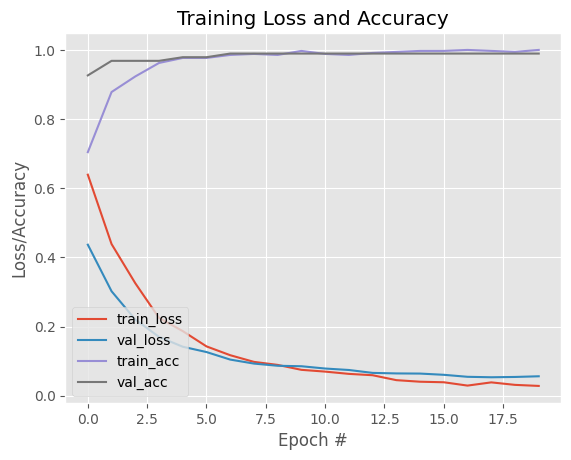

In [25]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")